# Visualization of vowel space density with convexhull

In this notebook, the vowel space densities and corresponding convexhull measures (at inputted density-cutoff) will be visualized for each speaker across each task type.

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial import distance
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/formants.csv")
df.head()

,Video ID,Vowel,Vowel_onset_time,Time_of_formant_measurements,Time_from_vowel_onset,F1,F2,Participant,Task,Word
0,p113_int,o,0.19,0.195,0.005,438.507357,1371.707968,p113,int,no
1,p113_int,o,0.19,0.200,0.010,438.708664,1345.533822,p113,int,no
2,p113_int,o,0.19,0.205,0.015,438.909970,1319.359676,p113,int,no
3,p113_int,o,0.19,0.210,0.020,439.111277,1293.185530,p113,int,no
4,p113_int,o,0.19,0.215,0.025,439.312583,1267.011384,p113,int,no


In [3]:
# predetermine which participants you want to create images for
participants = ["p113", "p124"]

In [4]:
def images(df, participants, dens_cut):
    # subset of data with only speakers of interest
    df = df[df['Participant'].isin(participants)].copy()
        
    # define necessary functions and global variables
    ################################################################################
   
    def rem_outliers(df):
        print("Removal of outliers:")
        print("Initial length: ", len(df))
    
        # establish 25% and 75% for each formant
        f1_qrts = df.groupby(['Participant','Task','Vowel'])["F1"].describe()[['25%', '75%']]
        f2_qrts = df.groupby(['Participant','Task','Vowel'])["F2"].describe()[['25%', '75%']]
    
        # find interquartile range for each formant
        f1_qrts['IQR'] = f1_qrts['75%'] - f1_qrts['25%']
        f2_qrts['IQR'] = f2_qrts['75%'] - f2_qrts['25%']
    
        # determine upper limit for each formant
        f1_qrts['upper'] = f1_qrts['75%'] + (1.5 * f1_qrts['IQR'])
        f2_qrts['upper'] = f2_qrts['75%'] + (1.5 * f2_qrts['IQR'])
    
        # determine lower limit for each formant
        f1_qrts['lower'] = f1_qrts['25%'] - (1.5 * f1_qrts['IQR'])
        f2_qrts['lower'] = f2_qrts['25%'] - (1.5 * f2_qrts['IQR'])
    
        # create smaller df with only limits for each formant
        f1_limits = f1_qrts[['upper','lower']]
        f2_limits = f2_qrts[['upper','lower']]
    
        # merge limits into original df
        df = df.merge(f1_limits, left_on = ["Participant", 'Task', "Vowel"], right_index = True)
        df = df.merge(f2_limits, left_on = ["Participant", "Task", "Vowel"], right_index = True, suffixes = ("_f1", "_f2"))
    
        # drop rows with outlier formants
        df = df[(df["F1"] > df["lower_f1"]) & (df["F1"] < df["upper_f1"])]
        df = df[(df["F2"] > df["lower_f2"]) & (df["F2"] < df["upper_f2"])]

        print("Final length: ", len(df))
        return df
    
    ####################################################################################
    # define function to scale all formant measures
    def scale_formants(df):
        medians = df.groupby(["Participant","Task"])[["F1", "F2"]].median()

        df = df.merge(medians, left_on = ["Participant","Task"], right_index = True, suffixes = ("","_med"))
        df["F1_vsd"] = (df["F1"]-df["F1_med"])/df["F1_med"]
        df["F2_vsd"] = (df["F2"]-df["F2_med"])/df["F2_med"]
        
        print("Formant data scaled")
        return df 
    
    ####################################################################################
    
    # define variable `grid`
    xvalues = np.flip(np.arange(-1., 1.01, 0.01))
    yvalues = np.arange(-1., 1.01, 0.01)

    grid = [(round(x, 2), round(y,2)) for x in xvalues for y in yvalues]
      
    #####################################################################################
    
    # define function get_density
    def density(grid, df):
        density_dict = {}
        for c in grid:
            # define x and y coordinate
            x = c[0]
            y = c[1]
    
            # define max and min coordinates that form a square of length 0.1 around the coordinate
            x_max = x + 0.05
            x_min = x - 0.05
            y_max = y + 0.05
            y_min = y - 0.05
    
            # pull a subset of data that fall within the box
            opts = df[(df["F2_vsd"] <= x_max) &
               (df["F2_vsd"] >= x_min) &
               (df["F1_vsd"] <= y_max) &
               (df["F1_vsd"] >= y_min)].copy()
            opts_list = list(zip(opts["F2_vsd"], opts["F1_vsd"]))
    
             # define density for this point
            dens = 0
    
            for o in opts_list:
                # define x and y coordinate of each point in my data
                o_x = o[0]
                o_y = o[1]
        
                # calculate distance to grid point
                dist = distance.euclidean([x, y], [o_x, o_y])
        
                if dist <= 0.05:
                    dens += 1
        
            density_dict[c] = dens
    
        # convert to df
        density_df = pd.DataFrame(density_dict.items())
        density_df = density_df.rename(columns = {0: "coord", 1:"density"})
    
        # make grid into df
        grid_df = pd.DataFrame(grid, columns=["x", "y"])
        grid_df["coord"] = list(zip(grid_df["x"], grid_df["y"]))
    
        # join df and grid_df
        grid_df = grid_df.join(density_df.set_index('coord'), on="coord")
              
        return grid_df
    
    ##################################################################################
    # remove outliers by participant, by task, by vowel
    df = rem_outliers(df)
    
    # Lobanov normalization of formants, by participant by task
    df = scale_formants(df)
    
    for i in participants:
        print("\n",i)
        
        # get subset of data for speaker across modality
        df_zoom = df[(df["Participant"]==i) & (df["Task"]== "wd")].copy()
        df_studio = df[(df["Participant"]==i) & (df["Task"]!= "wd")].copy()  
           
        # get density for each point across the modalities
        grid_wd_df = density(grid, df_zoom)
        print("Densities calculated for word list")
        grid_int_df = density(grid, df_studio)
        print("Densities calculated for interview")
              
        # scale density measures
        grid_wd_df["density_norm"] = grid_wd_df["density"].apply(lambda x: x/grid_wd_df["density"].max())
        grid_int_df["density_norm"] = grid_int_df["density"].apply(lambda x: x/grid_int_df["density"].max())
        
        # pull out coordinates at specified density cutoff and get areas
        grid_wd_density = grid_wd_df[grid_wd_df["density_norm"] >= dens_cut].copy()
        grid_int_density = grid_int_df[grid_int_df["density_norm"] >= dens_cut].copy()
    
        points_tuples_wd = list(grid_wd_density["coord"])
        points_tuples_int = list(grid_int_density["coord"])
    
        points_wd = [list(k) for k in points_tuples_wd]
        points_int = [list(k) for k in points_tuples_int]
    
        hull_wd = ConvexHull(points_wd)
        hull_int = ConvexHull(points_int)
        
        # areas
        area_wd = hull_wd.area
        area_int = hull_int.area

        # format into heatmap plots
        wd_pivot = pd.pivot_table(grid_wd_df,
                    index='y',
                    values='density_norm',
                    columns='x')
        int_pivot = pd.pivot_table(grid_int_df,
                    index='y',
                    values='density_norm',
                    columns='x')
    
        # reindex column order to reflect standard representation of vowel formant space
        columns = int_pivot.columns.tolist()
        columns = columns[::-1]
        
        wd_pivot = wd_pivot[columns]
        int_pivot = int_pivot[columns]
        
        # plot word list heatmap
        midpoint_wd = (wd_pivot.values.max() - wd_pivot.values.min()) / 2
        fig, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(wd_pivot, cmap="viridis", center=midpoint_wd,
                         xticklabels = 25, yticklabels = 25)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize = 13)
        cbar.ax.set_ylabel('Scaled Density', size=18)
        ax.set_xlabel('Normalized F2', fontsize = 20)
        ax.set_ylabel('Normalized F1', fontsize = 20)
        ax.set_title('Word list area = %f' %area_wd, fontsize = 22)
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), fontsize = 13)
        ax.set_yticklabels(ax.yaxis.get_majorticklabels(), fontsize = 13, rotation = 0)
        plt.savefig('figs/'+str(i) + '_wd.svg', format='svg', dpi=10)
        print("Word list heatmap saved")
        
        # plot interview heatmap
        midpoint_int = (int_pivot.values.max() - int_pivot.values.min()) / 2
        fig, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(int_pivot, cmap="viridis", center=midpoint_int,
                         xticklabels = 25, yticklabels = 25)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize = 13)
        cbar.ax.set_ylabel('Scaled Density', size=18)
        ax.set_xlabel('Normalized F2', fontsize = 20)
        ax.set_ylabel('Normalized F1', fontsize =20)
        ax.set_title('Interview area = %f' %area_int, fontsize = 22)        
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), fontsize = 13)
        ax.set_yticklabels(ax.yaxis.get_majorticklabels(), fontsize = 13, rotation = 0)
        plt.savefig('figs/'+ str(i) + '_int.svg', format='svg', dpi=10)
        print("Interview heatmap saved")
        
        # plot wd convexhull
        points_wd = np.array(points_wd)
        fig, ax = plt.subplots()
        for simplex in hull_wd.simplices:
            ax.plot(points_wd[simplex, 0], points_wd[simplex, 1], 'y-')
        plt.xlim([-1,1])
        plt.ylim([-1,1])
        # invert x- and y- axes
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.savefig('figs/' + str(i) + '_wd_convex.svg', format='svg', dpi=10, transparent=True)
        print("Word list convexhull saved")
        
        # plot interview convexhull
        points_int = np.array(points_int)
        fig, ax = plt.subplots()
        for simplex in hull_int.simplices:
            ax.plot(points_int[simplex, 0], points_int[simplex, 1], 'y-')
        plt.xlim([-1,1])
        plt.ylim([-1,1])
        # invert x- and y- axes
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.savefig('figs/' + str(i) + '_int_convex.svg', format='svg', dpi=10, transparent=True)
        print("Interview convexhull saved")

Removal of outliers:
Initial length:  60527
Final length:  55533
Formant data scaled

 p113
Densities calculated for word list
Densities calculated for interview
Word list heatmap saved
Interview heatmap saved
Word list convexhull saved
Interview convexhull saved

 p124
Densities calculated for word list
Densities calculated for interview
Word list heatmap saved
Interview heatmap saved
Word list convexhull saved
Interview convexhull saved


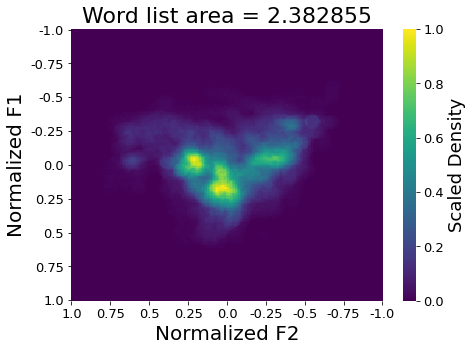

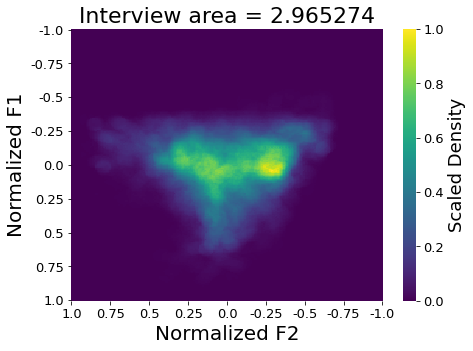

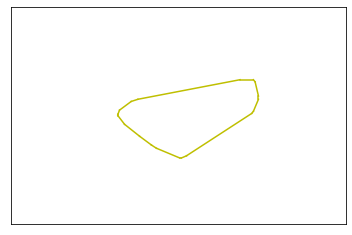

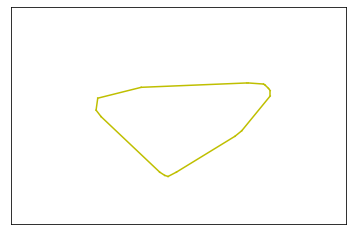

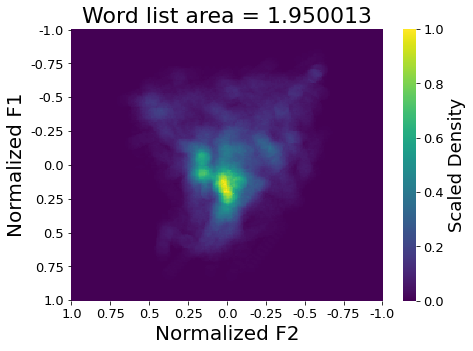

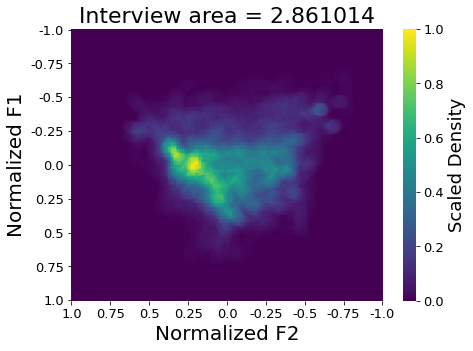

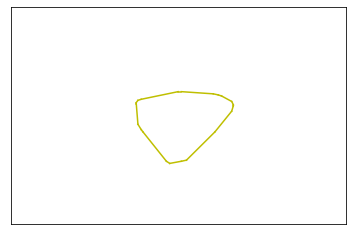

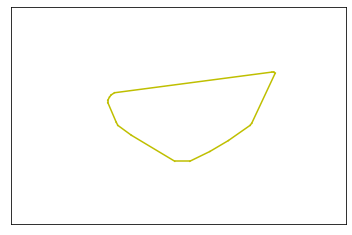

In [5]:
dens_cut = 0.25
images(df, participants, dens_cut)